# SHAP DeepExplainer on simulated DNA sequence
Computing importance scores on simulated genomic data using 3 different variants of DeepLIFT: integrated gradients, guided backprop, and rescale on the conv layers. This example is inspired from the [DeepLIFT example](https://

1.   List item
2.   List item

github.com/kundajelab/deeplift/blob/master/examples/genomics/genomics_simulation.ipynb). The original model and data can be found [here](https://raw.githubusercontent.com/kundajelab/deeplift/d95d41d/examples/genomics/grab_model_and_data.sh).

In [1]:
%%capture 
! [[ ! -f sequences.simdata.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelJson.json ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelWeights.h5 ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelWeights.h5
! [[ ! -f test.txt.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

In [2]:
%%capture
!pip install simdna 
!pip install deeplift
!pip install shap
!pip install einops

In [3]:
%matplotlib inline

import simdna.synthetic as synthetic
import gzip

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

from deeplift.dinuc_shuffle import dinuc_shuffle
from deeplift.visualization import viz_sequence
import shap

from einops import rearrange
import numpy as np


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# Data Handling Functions

def onehot_sequence(seq: str):
  base_index_mapper = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
  onehot = np.zeros(shape=(len(seq), 4))
  for (ind, char) in enumerate(seq.upper()):
    if char in base_index_mapper:
      onehot[ind, base_index_mapper[char]] = 1
  return onehot


def shuffle_several_times(seqs: np.array, reps=100):
  seqs = np.array(seqs)
  assert len(seqs.shape) == 3
  sep_shuffled_seqs = np.array([dinuc_shuffle(s, num_shufs=reps) for s in seqs])
  shuffle_out = rearrange(sep_shuffled_seqs, "b r l n -> (b r) l n")
  return shuffle_out
    


## Load in Data and Model

In [5]:
data_filename = "sequences.simdata.gz"
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = [x.decode("utf-8").rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)
onehot_data = np.array([onehot_sequence(seq) for seq in data.sequences])

In [6]:
keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

keras_model = tf.keras.models.model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

## Compute Importance Scores

In [7]:
seqs_to_explain = onehot_data[[0,3,9]] #these three are positive for task 0
dinuc_shuff_explainer = shap.DeepExplainer((keras_model.input, keras_model.output[:,0]), shuffle_several_times)
raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain, check_additivity=False)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



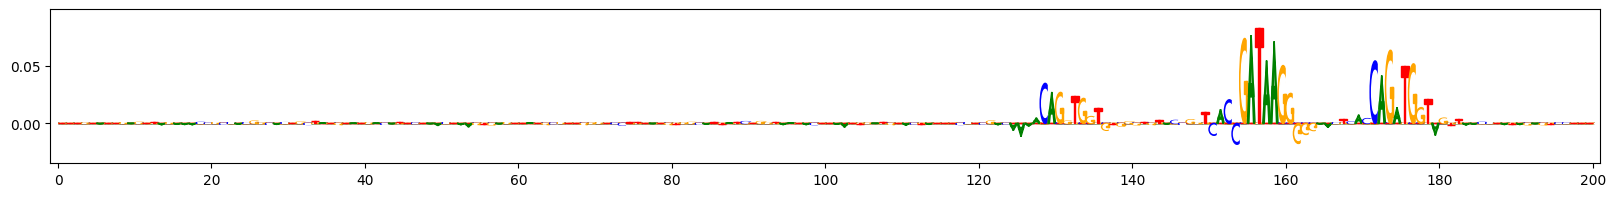

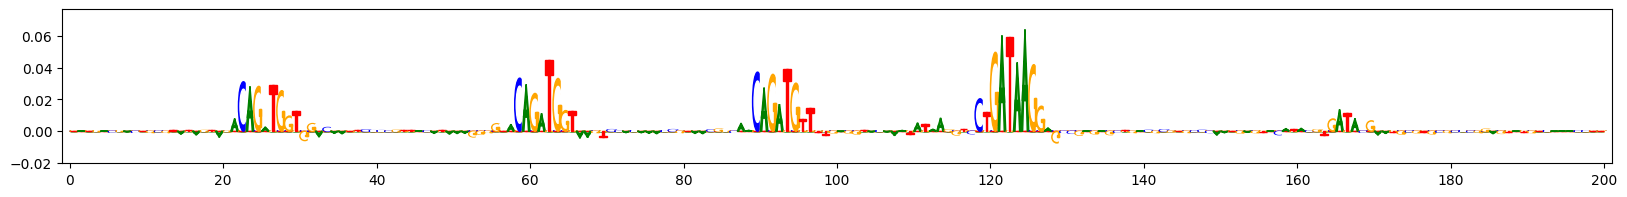

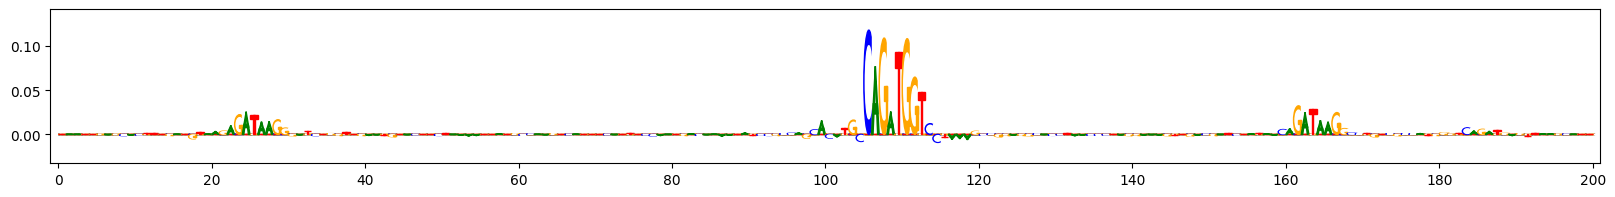

In [8]:
#project the importance at each position onto the base that's actually present
dinuc_shuff_explanations = np.sum(raw_shap_explanations,axis=-1)[:,:,None]*seqs_to_explain
for dinuc_shuff_explanation in dinuc_shuff_explanations:
    viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)